# Coding Assignment 06

In [1]:
##Ignore all the warning message
import warnings
warnings.filterwarnings("ignore")

In [44]:
import pandas as pd
import regex as re
import numpy as np
from collections import Counter
from tqdm.auto import tqdm ### tqdm provdes a progress bar for computating a task
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from spacy.matcher import DependencyMatcher
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import matplotlib.pyplot as plt
import wordcloud #will use for the word cloud plot
#from wordcloud import WordCloud, STOPWORDS # optional to filter out the stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


# Task 1

Read the dataset as in TextInsight.ipynb discussed in Module 2. Extract the data for the most recent 10 years into a new dataframe. Clean the data and generate, for each article, lemmas, nounds, and noun-phrases.

In [3]:
##Read the dataset

git_root = "https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master"
file = f"{git_root}/data/un-general-debates/un-general-debates-blueprint.csv.gz"

df1 = pd.read_csv(file)

##Extract the data for the most recent 10 years into a new dataframe. 
most_recent_data = df1[df1['year']>=2005] #last year was 2015 so filterd out all data <2005

df = most_recent_data[['text']] #eliminate irrelavent columns for this assignment

df = df.dropna()


In [4]:
"""
Clean the data and generate, for each article, lemmas, nounds, and noun-phrases.
"""
##clean the text 

def clean(text):
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    # removing mentions 
    text = re.sub("@\S+", "", text)
    text = re.sub('[-%!@#$]', '', text)
    text = re.sub("@[A-Za-z0-9]+","",text)
    #Removing numerical data
    text = re.sub(r'\d+','',text)
    #Removing currencies 
    text = re.sub(r'[\$\d+\d+\$]','',text)
    #Handling all date formats
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    #Removing a hyperlink
    text = re.sub(r'https?:\/\/.*[\r\n]*', '',text)
    #Removing all punctuation
    text = re.sub(r'[^a-z0-9A-Z_]',' ',text)
    return text.strip()

df['text'] = df['text'].apply(clean)

In [27]:
nlp = spacy.load("en_core_web_sm")
nouns = ["NOUN","PROPN"]

for i, row in tqdm(df.iterrows(), total=len(df)):
    doc = nlp(str(row["text"])) ### tokenization
#     print (doc)
    
#     df.at[i, "lemmas"] = " ".join([token.lemma_ for token in doc])    ## generate lemmas
    df.at[i, "lemmas"] = " ".join(
            token.lemma_.lower() for token in doc
                if token.lemma_.lower() not in nlp.Defaults.stop_words and token.is_alpha)
    
    df.at[i, "nouns"] = \
        " ".join([token.lemma_.lower() for token in doc 
                  if token.pos_ in nouns and 
                  token.lemma_.lower() not in nlp.Defaults.stop_words and token.is_alpha])  ##generate nouns
        
    df.at[i, "noun_phrase"] = "  ".join([nph.text.lower() for nph in doc.noun_chunks
                                        if nph.text.lower() not in nlp.Defaults.stop_words]) #noun phrase 

  0%|          | 0/2112 [00:00<?, ?it/s]

In [6]:
df

,text,lemmas,nouns,noun_phrase
5395,I have the honour to inform the members of the...,honour inform member general assembly successf...,honour member conclusion election place countr...,the honour the members the general assembly ...
5396,It is with great honour that I take this floor...,great honour floor assembly outset like congra...,honour floor outset behalf election presidency...,great honour this floor the president behal...
5397,Let me first convey on behalf of the people a...,let convey behalf people government albania pr...,behalf people sentiment sympathy friendship so...,behalf the people the government albania t...
5398,At the beginning of the third millennium fast...,beginning millennium fast mean travel begin ni...,beginning millennium mean travel century railr...,the beginning faster means travel the ninet...
5399,It is my pleasure to take this opportunity to ...,pleasure opportunity congratulate election pre...,pleasure opportunity election session annivers...,my pleasure this opportunity your election ...
...,...,...,...,...
7502,On behalf of the people and the Government of ...,behalf people government yemen like congratula...,behalf people session success today city joy m...,behalf the people the government yemen the...
7503,Seventy years have passed since the establishm...,seventy year pass establishment united nations...,year establishment people change place reform ...,seventy years the establishment people many...
7504,I should like to congratulate the President an...,like congratulate president country denmark el...,country election session support presidency th...,the president his country his election pres...
7505,I would like to begin by thanking the Secretar...,like begin thank secretarygeneral express grat...,gratitude convening session anniversary opport...,the secretarygeneral my gratitude the conven...


# Task 2

Compute TF-IDF values for lemmas, excluding spaCy stopwords.

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
## tf-idf excluding spaCy stop words
stopwords |= {"mr","s",'dear', 'regards'}
tfidf = TfidfVectorizer(stop_words=stopwords)

###TFIDF for lemmas
tfidf_lemmas = tfidf.fit_transform(df["lemmas"].map(str))*1000

transformed_lemmas_as_array = tfidf_lemmas.toarray()

for counter, doc in enumerate(transformed_lemmas_as_array):
    # construct a dataframe
    tf_idf_tuples = list(zip(tfidf.get_feature_names(), doc))
    df_lemma = pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)


In [34]:
df_lemma.dropna().head(20)

,term,score
0,united,202.801726
1,nations,164.639673
2,agenda,148.491384
3,continent,145.880663
4,union,129.111169
5,zimbabwe,126.856951
6,development,119.791099
7,inclusivity,113.256406
8,africa,113.035037
9,peace,112.068589


# Task 3

Compute TF-IDF values for noun-phrases, excluding spaCy stopwords.

In [35]:
###TFIDF for noun-phrase
tfidf_np = tfidf.fit_transform(df["noun_phrase"].map(str))*1000

transformed_np_as_array = tfidf_np.toarray()

for counter, doc in enumerate(transformed_np_as_array):
    # construct a dataframe
    tf_idf_tuples = list(zip(tfidf.get_feature_names(), doc))
    df_np = pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)

df_np.dropna().head(20)

,term,score
0,united,179.968020
1,nations,179.457684
2,continent,149.992443
3,union,137.210253
4,inclusivity,132.165677
5,peace,119.228986
6,development,117.935425
7,africa,112.964392
8,agenda,111.526698
9,zimbabwe,104.540819


# Task 4

Create a wordcloud image for the top 80 lemmas in the entire corpus. Define the score for a lemma in the corpus to be the summation of the tf-idf values of the lemmas with respect to individual documents in the corpus.

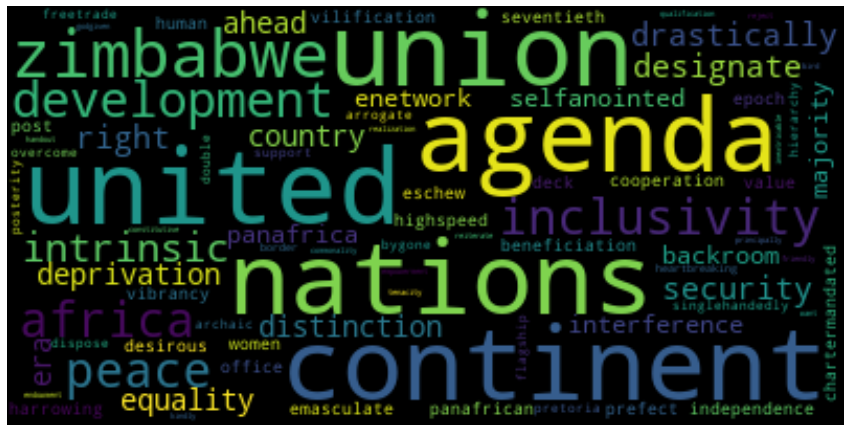

In [83]:
text = df_lemma.term[0:80] ##top 80 lemmas

#Now let's add a string value instead to make our Series clean:
word_string=" ".join(text.str.lower())


#And - plotting:

plt.figure(figsize=(15,15))
wc = WordCloud(background_color="black", stopwords = STOPWORDS, max_words=2000, max_font_size= 50,  width=400, height=200)
wc.generate(word_string)

plt.imshow(wc.recolor( colormap= 'viridis' , random_state=17), interpolation="bilinear")
plt.axis('off')
plt.show()

# Task 5

Create a wordcloud for the top 50 nouns in the entire corpus. 

In [68]:
###TFIDF for nouns
tfidf_nouns = tfidf.fit_transform(df["nouns"].map(str))*1000

transformed_nouns_as_array = tfidf_nouns.toarray()

for counter, doc in enumerate(transformed_nouns_as_array):
    # construct a dataframe
    tf_idf_tuples = list(zip(tfidf.get_feature_names(), doc))
    df_nouns = pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)

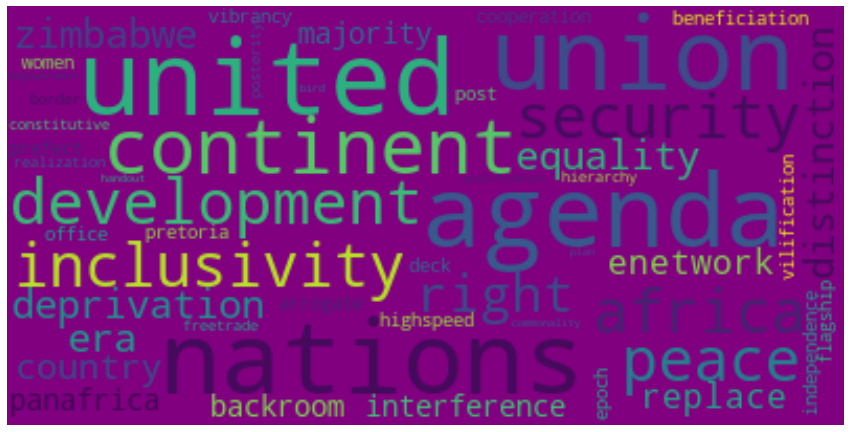

In [79]:
text1 = df_nouns.term[:50] ##top 50 nouns

#Now let's add a string value instead to make our Series clean:
word_string1=" ".join(text1.str.lower())

#word_string

#And - plotting:

plt.figure(figsize=(15,15))
wc1 = WordCloud(background_color="purple", stopwords = STOPWORDS, max_words=2000, max_font_size= 50,  width=400, height=200)
wc1.generate(word_string1)

plt.imshow(wc1.recolor( colormap= 'viridis', random_state=42), interpolation="bilinear")
plt.axis('off')
plt.show()

# Task 6

Create a bar graph for the top 20 noun-phrases for the entire corpus. Define the score for a noun-phrase to be the summation of the tf-idf values of the nouns contained in the noun-phrase. Note: Some words in in a noun-phrase may belong to the stopword list that have been dropped. For such words, assign a small value of 0.0001 as its tf-idf value. Given below is such a bar plot.

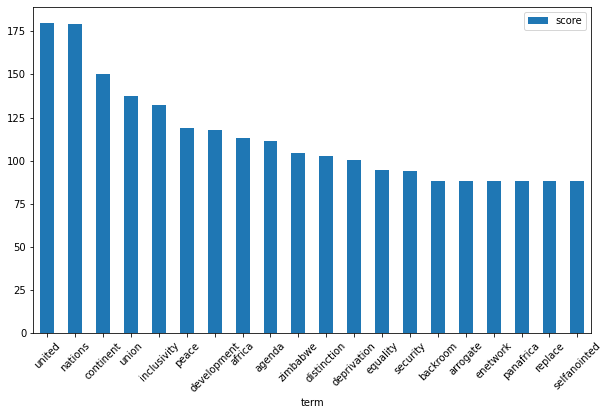

In [84]:
df_np[:20].plot(x='term', y='score', figsize=(10,6), kind ='bar')

plt.xticks(rotation=45)

plt.show()